Cоревнование на:

https://www.kaggle.com/competitions/gb-credit-default/overview

 Задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).
 
 Целевая метрика для этого соревнования -  F1-Score.

from google.colab import drive
drive.mount('/content/drive')

!pip3 install catboost

!pip install category_encoders

!pip install bayesian-optimization

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from bayes_opt import BayesianOptimization


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

In [3]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

### Использованные в ноутбуке функции

   С ноутбуками работал на разных платформах, в т.ч. на Google Collab, поэтому не вынес  самописные функции в отдельный файл, извините.

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n') # вывод матрицы ошибок
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_binary',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print(f"cross_validation: ")
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                          scoring,
                                          cv_res['test_score'].mean(),
                                          cv_res['test_score'].std() * 2))
    return cv_res['test_score'].mean(), cv_res['test_score'].std() * 2

In [9]:
def choise_features(train, test, cat_feats):
    """Функция для проверки метрик и выбора признаков, cat_feats для категориальных признаков"""
    X_train = train.drop(columns=['Credit_Default'])
    y_train = train['Credit_Default']
    X_test = test.drop(columns=['Credit_Default'])
    y_test = test['Credit_Default']

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'cat_features': cat_feats,
     'eval_metric':'F1',
     'early_stopping_rounds':50
    }    

    model_catb = catb.CatBoostClassifier(**frozen_params) #, iterations=300, max_depth=5)
    model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
    evaluate_preds(model_catb, X_train, X_test, y_train, y_test)
    
    run_cv(model_catb, kfold_cv, X_train, y_train, scoring='f1', model_name="model_catb")
    
    y_pred = model_catb.predict_proba(X_test)
    for i in np.linspace(0.1, 0.9, num=30):
        print(f"threshold : {i}")
        print(classification_report(y_test, (y_pred[:, 1] > i) * 1))
        print('***************************')
    
    feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), \
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)


    return feature_importances

In [10]:
def choise_features_final(model, train, test, cat_feats):
    """Функция для проверки метрик и выбора признаков, cat_feats для категориальных признаков"""
    X_train = train.drop(columns=['Credit_Default'])
    y_train = train['Credit_Default']
    X_test = test.drop(columns=['Credit_Default'])
    y_test = test['Credit_Default']

    model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
    
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    
    #run_cv(model_catb, kfold_cv, X_train, y_train, scoring='f1', model_name="model_catb")
    
    y_pred = model.predict_proba(X_test)
    for i in np.linspace(0.1, 0.9, num=50):
        print(f"threshold : {i}")
        print(classification_report(y_test, (y_pred[:, 1] > i) * 1))
        print('***************************')
    
    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), \
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)


    return feature_importances

In [11]:
def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [12]:
#Снижение размерности до 3х компонент
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames)

In [14]:
def one_hot(train, valid, test, col):
    """ Функция кодирования категориальной колонки с помощью get_dummies"""
    if (sorted(list(valid[col].unique())) != sorted(list(train[col].unique()))) |\
               (sorted(list(test[col].unique())) != sorted(list(train[col].unique()))):
        print("Количество значений в признаке различно для выбранных датасетов.")

    train1 = train.copy()
    valid1 = valid.copy()
    test1 = test.copy()

    train_dummies = pd.get_dummies(train1[col], prefix=f'One_Hot_{col}', prefix_sep='_')
    valid_dummies = pd.get_dummies(valid1[col], prefix=f'One_Hot_{col}', prefix_sep='_')
    test_dummies = pd.get_dummies(test1[col], prefix=f'One_Hot_{col}', prefix_sep='_')

    res_cols = list(set(train_dummies.columns.to_list()) & set(valid_dummies.columns.to_list()) &\
                    set(test_dummies.columns.to_list()))
    
    train1 = train1.drop(columns=col).join(train_dummies[res_cols])
    valid1 = valid1.drop(columns=col).join(valid_dummies[res_cols])
    test1 = test1.drop(columns=col).join(test_dummies[res_cols])

    return train1, valid1, test1

**Пути к директориям и файлам**

In [15]:
if 0:
    TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/CREDIT_DEFAULT_CW/train.csv'
    TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/CREDIT_DEFAULT_CW/test.csv'

In [16]:
if 1:
    TRAIN_DATASET_PATH = 'train.csv'
    TEST_DATASET_PATH = 'test.csv'

### 1. Загрузка датасета ###

In [17]:
train_df = pd.read_csv(TRAIN_DATASET_PATH) # читаем данные из файла трейн
train_df.head() # смотрим первые 5 строк

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [18]:
train_df['id'] = train_df.index

In [19]:
train_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,id
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,7495
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1,7496
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0,7497
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0,7498


In [20]:
test_df = pd.read_csv(TEST_DATASET_PATH) # читаем данные из файла тест
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


### 2. Предобработка датасета ###

In [21]:
test_df['id'] = test_df.index

In [22]:
train_df['CS_outlier'] = 0
train_df.loc[train_df['Credit Score'] > 850, 'CS_outlier'] = 1
train_df.loc[train_df['CS_outlier']==1]['Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

In [23]:
test_df['CS_outlier'] = 0
test_df.loc[test_df['Credit Score'] > 850, 'CS_outlier'] = 1

In [24]:
# Заменить значения перед предсказанием.
test_df_CS_outlier = test_df.loc[test_df['CS_outlier']==1][['id', 'CS_outlier']].\
     rename(columns={'CS_outlier': 'Credit Default'})
test_df_CS_outlier.head(2)

,id,Credit Default
2,2,1
12,12,1


In [25]:
def preprocessing(df):
    """ Функция предварительной предобработки данных """
    df=df.rename(columns={'Home Ownership': 'Home_Ownership', 
                                      'Annual Income': 'Annual_Income',
                                      'Years in current job': 'Years_in_current_job',
                                      'Tax Liens': 'Tax_Liens', 
                                      'Number of Open Accounts': 'Number_of_Open_Accounts', 
                                      'Years of Credit History': 'Years_of_Credit_History', 
                                      'Maximum Open Credit': 'Maximum_Open_Credit', 
                                      'Number of Credit Problems': 'Number_of_Credit_Problems', 
                                      'Months since last delinquent': 'Months_since_last_delinquent', 
                                      'Current Loan Amount': 'Current_Loan_Amount', 
                                      'Current Credit Balance': 'Current_Credit_Balance', 
                                      'Monthly Debt': 'Monthly_Debt', 
                                      'Credit Score': 'Credit_Score', 
                                      'Credit Default': 'Credit_Default'})

    df.loc[df['Purpose']=='renewable energy', 'Purpose'] = np.nan
    df.loc[:, ['Months_since_last_delinquent', 'Bankruptcies', 'Credit_Score']] = \
       df.loc[:, ['Months_since_last_delinquent', 'Bankruptcies', 'Credit_Score']].fillna(value=0)
    df['Annual_Income'].fillna(value=df['Annual_Income'].mean(), inplace=True)
    df['Years_in_current_job'] = df['Years_in_current_job'].fillna('0').\
        map({'0': 0, '< 1 year': 1, '1 year': 2, '2 years': 3,
        '3 years': 4, '4 years': 5, '5 years': 6, '6 years': 7, 
        '7 years': 8, '8 years': 9, '9 years': 10, '10+ years': 11})
    df.loc[df['Years_in_current_job'] == 99999999, 'Years_in_current_job'] = 0
    df.dropna(inplace=True)
    
    return df

In [26]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [27]:
def preprocessing2(train_df, test_df):
    """ Функция окончательной предобработки данных, выявляющая большой
    кластер наблюдений, в которых таргет равен нулю. """
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.cluster import KMeans
    NUMERIC_FEATURE_NAMES = ['Annual_Income','Tax_Liens','Number_of_Open_Accounts',
        'Years_of_Credit_History','Maximum_Open_Credit','Number_of_Credit_Problems',
        'Months_since_last_delinquent','Bankruptcies','Current_Loan_Amount',
        'Current_Credit_Balance','Monthly_Debt','Credit_Score']
    cat_feats = train_df.select_dtypes(exclude = [np.number]).columns.to_list()
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
    #enc.set_params(encoded_missing_value=9999).fit(train_df[cat_feats])
    enc.fit(train_df[cat_feats])
    train_df[cat_feats] = enc.transform(train_df[cat_feats])
    test_df[cat_feats] = enc.transform(test_df[cat_feats])
    train_df[cat_feats] = train_df[cat_feats].astype("str")
    test_df[cat_feats] = test_df[cat_feats].astype("str")
    dim_reducer3d, components_3d = reduce_dims(train_df.drop(columns=['Credit_Default']), dims=3, method='pca')
    components = pd.DataFrame(dim_reducer3d.transform(test_df), columns=components_3d.columns.to_list())
    kmeans = KMeans(n_clusters=2, random_state=42).fit(components_3d)
    display_components_in_3D_space(components_3d, kmeans.predict(components_3d))
    display_components_in_3D_space(components, kmeans.predict(components))
    train_df['pca'] = kmeans.predict(components_3d)
    test_df['pca'] = kmeans.predict(components)
    train_df['pca'] = train_df['pca'].astype("str")
    test_df['pca'] = test_df['pca'].astype("str")
    return train_df, test_df

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f34af1ef040>
Traceback (most recent call last):
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callba

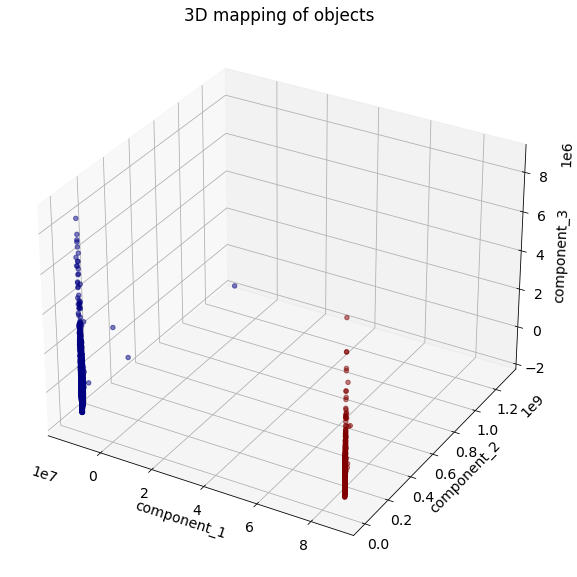

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f34ae4e0b80>
Traceback (most recent call last):
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


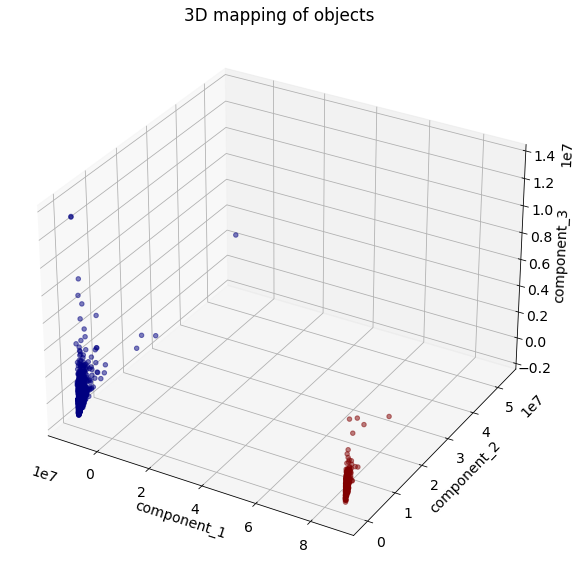

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f34ae099ee0>
Traceback (most recent call last):
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/fn/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callba

In [28]:
train_df, test_df = preprocessing2(train_df, test_df)

In [29]:
# Одной кроссвалидации оказалось не достаточно, пришлось выделять еще валидационную выборку.
#  Однотнаправленное движение метрики на валидации и кроссвалидации оказалось достаточным 
# условием тестирования метрики.
train, valid = train_test_split(train_df, train_size=0.75, random_state=42)

In [31]:
cat_feats=['Home_Ownership', 'Term', 'CS_outlier']

In [32]:
#choise_features(train.drop(columns=['id']), valid.drop(columns=['id']), cat_feats)

In [33]:
#choise_features(train.drop(columns=['id', 'Purpose']), valid.drop(columns=['id', 'Purpose']),
 #               ['Home_Ownership', 'Term', 'CS_outlier'])

In [35]:
train_df.loc[train_df['pca']=='1'].Credit_Default.value_counts()

0    870
Name: Credit_Default, dtype: int64

In [36]:
train_df['pca'].value_counts()

0    6628
1     870
Name: pca, dtype: int64

In [37]:
test_df['pca'].value_counts()

0    2203
1     297
Name: pca, dtype: int64

### 3. Делю датасет по 'pca' ###

In [38]:
# эта часть датасета пойдет дальше в обучение
train_df0 = train_df.loc[train_df['pca']=='0']
test_df0 = test_df.loc[test_df['pca']=='0']

In [39]:
test_df0.loc[test_df0['CS_outlier']==1].shape

(160, 19)

In [40]:
# отделяю часть датасета, содержащего одни нули на таргете
train_df1 = train_df.loc[train_df['pca']=='1']
test_df1 = test_df.loc[test_df['pca']=='1']

In [41]:
test_df1.loc[test_df1['CS_outlier']==1].shape

(0, 19)

In [42]:
train, valid = train_test_split(train_df0, train_size=0.75)

In [44]:
NUMERIC_FEATURE_NAMES = ['Annual_Income','Years_in_current_job','Tax_Liens','Number_of_Open_Accounts',
    'Years_of_Credit_History','Maximum_Open_Credit','Number_of_Credit_Problems','Months_since_last_delinquent',
    'Bankruptcies','Current_Loan_Amount','Current_Credit_Balance','Monthly_Debt','Credit_Score', 'Purpose']

In [45]:
train[NUMERIC_FEATURE_NAMES] = train[NUMERIC_FEATURE_NAMES].astype("float32")
valid[NUMERIC_FEATURE_NAMES] = valid[NUMERIC_FEATURE_NAMES].astype("float32")

choise_features(train.drop(columns=['id']), valid.drop(columns=['id']), cat_feats)

In [46]:
NUMERIC_FEATURE_NAMES = ['Annual_Income','Tax_Liens','Number_of_Open_Accounts',
        'Years_of_Credit_History','Maximum_Open_Credit','Number_of_Credit_Problems',
        'Months_since_last_delinquent','Bankruptcies','Current_Loan_Amount',
        'Current_Credit_Balance','Monthly_Debt','Credit_Score']

scaler = RobustScaler()

train_norm = train.copy() 
valid_norm = valid.copy()
train_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(train_norm[NUMERIC_FEATURE_NAMES]) 
valid_norm[NUMERIC_FEATURE_NAMES] = scaler.transform(valid_norm[NUMERIC_FEATURE_NAMES]) 
valid_norm.head()


,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Purpose,Term,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score,Credit_Default,id,CS_outlier,pca
3129,3.0,-0.669016,2.0,0.0,-0.833333,-0.216868,-0.847858,0.0,2.241379,0.0,3.0,0.0,-0.345069,-0.836650,-0.416851,-0.122449,0,3129,0,0
273,1.0,0.000000,11.0,0.0,-0.833333,3.240964,0.849585,0.0,0.000000,0.0,10.0,1.0,-0.137755,0.092360,-0.794837,-7.336735,0,273,0,0
598,3.0,0.000000,11.0,0.0,-0.166667,-0.674699,-0.243479,1.0,0.000000,1.0,3.0,1.0,-0.338675,-0.213317,-0.423522,-7.336735,0,598,0,0
1633,1.0,0.328018,6.0,0.0,-0.666667,0.373494,-0.676153,0.0,0.655172,0.0,3.0,1.0,0.697894,-0.769641,0.604938,0.214286,0,1633,0,0
4672,2.0,-1.738810,1.0,0.0,-1.166667,0.072289,-0.150846,0.0,0.000000,0.0,5.0,0.0,-0.610945,-0.301349,-0.538375,0.193878,0,4672,0,0


In [47]:
test_df0_norm = test_df0.copy()
test_df0_norm[NUMERIC_FEATURE_NAMES] = scaler.transform(test_df0_norm[NUMERIC_FEATURE_NAMES]) 

In [48]:
test_df0_norm.loc[test_df0_norm['CS_outlier']==1].shape

(160, 19)

In [49]:
train_norm = train_norm[['id', 'Home_Ownership', 'Annual_Income', 'Years_in_current_job', 'Tax_Liens',
       'Number_of_Open_Accounts', 'Years_of_Credit_History',
       'Maximum_Open_Credit', 'Number_of_Credit_Problems',
       'Months_since_last_delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt',
       'Credit_Score', 'Credit_Default', 'pca', 'CS_outlier']]

In [50]:
valid_norm = valid_norm[['id', 'Home_Ownership', 'Annual_Income', 'Years_in_current_job', 'Tax_Liens',
       'Number_of_Open_Accounts', 'Years_of_Credit_History',
       'Maximum_Open_Credit', 'Number_of_Credit_Problems',
       'Months_since_last_delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt',
       'Credit_Score', 'Credit_Default', 'pca', 'CS_outlier']]

In [51]:
test_df0_norm = test_df0_norm[['id', 'Home_Ownership', 'Annual_Income', 'Years_in_current_job', 'Tax_Liens',
       'Number_of_Open_Accounts', 'Years_of_Credit_History',
       'Maximum_Open_Credit', 'Number_of_Credit_Problems',
       'Months_since_last_delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt',
       'Credit_Score', 'pca', 'CS_outlier']]

In [52]:
test_df0_norm[cat_feats] = test_df0_norm[cat_feats].astype("str")

In [53]:
test_df0_norm.loc[test_df0_norm['CS_outlier']=='1'].shape

(160, 19)

In [54]:
# исходный датасет
#choise_features(train_norm.drop(columns=['id']), valid_norm.drop(columns=['id']), cat_feats)

Из-за высокой значимости CS_outlier обнулились важности почти всех метрик, надо датасет делить.

### 4. Делю датасет по CS_outlier ###

In [55]:
def result_CS_out(train_norm, test_df1, test_df0_norm, cat_feats, treshold=0.5):
    """Исправленная функция записи предсказания в файл prediction.csv"""
    train_0 = train_norm.loc[train_norm['CS_outlier']==0]
    test_0 = test_df0_norm.loc[test_df0_norm['CS_outlier']==0]
    #train_1 = train_norm.loc[train_norm['CS_outlier']=='1']
    test_1 = test_df0_norm.loc[test_df0_norm['CS_outlier']==1]
    disbalance = train_0['Credit_Default'].value_counts()[0] / train_0['Credit_Default'].value_counts()[1]
    params = {'eval_metric': 'F1'}
    final_model = catb.CatBoostClassifier(**params, 
                                      silent=True, 
                                      random_state=42, 
                                      cat_features=cat_feats, 
                                      class_weights=[1, disbalance]) 
    final_model.fit(train_0.drop(columns=['id', 'Credit_Default']), train_0['Credit_Default'])
    y_test_pred0 = final_model.predict_proba(test_0.drop(columns=['id']))
    y_test_pred0 = (y_test_pred0[:, 1] > treshold) * 1
    test_0['Credit Default'] = y_test_pred0
    #test_df0 = test_0.copy()
    #test_df0.loc[test_df0['CS_outlier'] == 1, 'Credit Default'] = 1
    test_preds1 = [0]*297
    test_df1['Credit Default'] = test_preds1
    
    test_preds11 = [1]*len(test_1)
    test_1['Credit Default'] = test_preds11
    
    result = pd.concat([test_0[['id', 'Credit Default']].rename(columns = {'id': 'Id'}), 
        test_df1[['id', 'Credit Default']].rename(columns = {'id': 'Id'}),
            test_1[['id', 'Credit Default']].rename(columns = {'id': 'Id'})]).sort_values(by='Id')
    result.to_csv('prediction.csv', index=False)
    return result

In [56]:
# Исправил ошибку
test_df0_norm['CS_outlier'] = test_df0_norm['CS_outlier'].astype("int8")

In [57]:
train_0 = train_norm.loc[train['CS_outlier']==0]
train_1 = train_norm.loc[train['CS_outlier']==1]
valid_0 = valid_norm.loc[valid['CS_outlier']==0]
valid_1 = valid_norm.loc[valid['CS_outlier']==1]

In [58]:
#choise_features(train_0.drop(columns=['id']), valid_0.drop(columns=['id']), cat_feats)

In [60]:
#test_00 = result_CS_out(train_norm, test_df1, test_df0_norm, cat_feats, treshold=0.4310344827586208)#

#test_00['Credit Default'].value_counts()

In [61]:
def result_CS_out(train_0, test_df1, test_df0_norm, cat_feats, treshold=0.5):
    """Исправленная функция записи предсказания в файл prediction.csv"""
    test_0 = test_df0_norm.loc[test_df0_norm['CS_outlier']==0]
    test_1 = test_df0_norm.loc[test_df0_norm['CS_outlier']==1]
    disbalance = train_0['Credit_Default'].value_counts()[0] / train_0['Credit_Default'].value_counts()[1]
    params = {'eval_metric': 'F1'}
    final_model = catb.CatBoostClassifier(**params, 
                                      silent=True, 
                                      random_state=42, 
                                      cat_features=cat_feats, 
                                      class_weights=[1, disbalance]) 
    final_model.fit(train_0.drop(columns=['id', 'Credit_Default']), train_0['Credit_Default'])
    y_test_pred0 = final_model.predict_proba(test_0.drop(columns=['id']))
    y_test_pred0 = (y_test_pred0[:, 1] > treshold) * 1
    test_0['Credit Default'] = y_test_pred0
    test_preds1 = [0]*297
    test_df1['Credit Default'] = test_preds1
    
    test_preds11 = [1]*len(test_1)
    test_1['Credit Default'] = test_preds11
    
    result = pd.concat([test_0[['id', 'Credit Default']].rename(columns = {'id': 'Id'}), 
            test_df1[['id', 'Credit Default']].rename(columns = {'id': 'Id'}),
            test_1[['id', 'Credit Default']].rename(columns = {'id': 'Id'})]).sort_values(by='Id')
    result.to_csv('prediction.csv', index=False)
    return result

"Причесываю" датасет

In [62]:
cat_feats = ['Home_Ownership', 'Term', 'CS_outlier']

In [63]:
valid_0 = valid_0[['id', 'Home_Ownership', 'Annual_Income', 'Years_in_current_job',
       'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History',
       'Maximum_Open_Credit', 'Number_of_Credit_Problems',
       'Months_since_last_delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt',
       'Credit_Score', 'pca', 'CS_outlier', 'Credit_Default']]

In [64]:
valid_0['Home_Ownership'] = valid_0['Home_Ownership'].astype('float32')
train_0['Home_Ownership'] = train_0['Home_Ownership'].astype('float32')
test_df0_norm['Home_Ownership'] = test_df0_norm['Home_Ownership'].astype('float32')

In [65]:

valid_0['Home_Ownership'] = valid_0['Home_Ownership'].astype('int8')
train_0['Home_Ownership'] = train_0['Home_Ownership'].astype('int8')
test_df0_norm['Home_Ownership'] = test_df0_norm['Home_Ownership'].astype('int8')

In [66]:
valid_0['Term'] = valid_0['Term'].astype('float32')
train_0['Term'] = train_0['Term'].astype('float32')
test_df0_norm['Term'] = test_df0_norm['Term'].astype('float32')

In [67]:
valid_0['Term'] = valid_0['Term'].astype('int8')
train_0['Term'] = train_0['Term'].astype('int8')
test_df0_norm['Term'] = test_df0_norm['Term'].astype('int8')

In [68]:
valid_0.drop(columns=['pca'], inplace=True)
train_0.drop(columns=['pca'], inplace=True)
test_df0_norm.drop(columns=['pca'], inplace=True)

### 5. Генерация искусственных наблюдений ###

Мной была создана The generative adversarial network (GAN) для генерации похожих трейну наблюдений. Выбрал самый удачный из сгенерированных датасетов.


In [ ]:
df_gun = pd.read_csv('df_gun.csv')
df_gun.head()

In [ ]:
df_res = pd.concat([train_0, df_gun]).drop_duplicates(subset=None, keep=False)
df_res.head()

In [69]:
if 0:
  test_00 = result_CS_out(df_res, test_df1, test_df0_norm, cat_feats,
                        treshold=0.4862068965517242)

### 6. Устранение дисбаланса по таргету ###

In [70]:
if 0:
    df_under = balance_df_by_target(df_tomek, 'Credit_Default', method='under')
    choise_features(df_under.drop(columns=['id']), valid_0.drop(columns=['id']), cat_feats)

In [71]:
df_under.to_csv('df_under.csv', index=False)

Результаты этой операции летали в таком диапазоне, что пришлось закрепить полученный датафрейм. Лучше, конечно, было закрепить random_state.

In [72]:
train_under = pd.read_csv("df_under.csv")

In [73]:
if 0:
  test_00 = result_CS_out(train_under, test_df1, test_df0_norm, cat_feats,
                        treshold=0.476)

In [74]:
train_under['Purpose'] = train_under['Purpose'].astype("str")

In [75]:
valid_0['Purpose'] = valid_0['Purpose'].astype("str")

In [76]:
cat_feats = ['Home_Ownership', 'Term', 'CS_outlier', 'Purpose']

In [77]:
#choise_features(train_under.drop(columns=['id']), valid_0.drop(columns=['id']), cat_feats)

In [78]:
if 0:
  test_00 = result_CS_out(train_under, test_df1, test_df0_norm, cat_feats,
                        treshold=0.489)

### 7. Тюнингую Катбуст

In [79]:
train_dataset = catb.Pool(data=train_under.drop(columns=['id', 'Credit_Default']),
                     label=train_under['Credit_Default'],
                     cat_features=cat_feats)

eval_dataset = catb.Pool(data=valid_0.drop(columns=['id', 'Credit_Default']),
                     label=valid_0['Credit_Default'],
                     cat_features=cat_feats)

model = catb.CatBoostClassifier(iterations=12000,
                           grow_policy="Depthwise",
                           #loss_function = 'RMSE',
                           eval_metric = 'AUC',
                           early_stopping_rounds = 1000,
                           random_state=42,
                           cat_features=cat_feats,
                           #task_type="GPU", # закомментировать, если не на GPU
                           #devices='0', # закомментировать, если не на GPU
                           verbose = False,
                           use_best_model=True
                         )

# Fit model
model.fit(train_dataset, eval_set=eval_dataset, logging_level='Silent', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [80]:
model.best_iteration_

605

In [81]:
choise_features_final(model, train_under.drop(columns=['id']), valid_0.drop(columns=['id']), cat_feats)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1448
           1       0.86      0.81      0.83      1448

    accuracy                           0.84      2896
   macro avg       0.84      0.84      0.84      2896
weighted avg       0.84      0.84      0.84      2896

TEST

              precision    recall  f1-score   support

           0       0.79      0.67      0.73      1121
           1       0.40      0.55      0.46       440

    accuracy                           0.64      1561
   macro avg       0.60      0.61      0.59      1561
weighted avg       0.68      0.64      0.65      1561

CONFUSION MATRIX

col_0             0    1
Credit_Default          
0               753  368
1               197  243
threshold : 0.1
              precision    recall  f1-score   support

           0       0.92      0.04      0.08      1121
           1       0.29      0.99      0.45       440

    accuracy                       

,feature_name,importance
0,Home_Ownership,2.654445
1,Annual_Income,11.997613
2,Years_in_current_job,4.749196
3,Tax_Liens,0.457794
4,Number_of_Open_Accounts,6.100629
5,Years_of_Credit_History,8.654398
6,Maximum_Open_Credit,8.436984
7,Number_of_Credit_Problems,1.247723
8,Months_since_last_delinquent,5.431462
9,Bankruptcies,0.839898


In [82]:
def result_CS_out_final(final_model, train_0, test_df1, test_df0_norm, cat_feats, treshold=0.5):
    """Исправленная функция записи предсказания в файл prediction.csv"""
    test_0 = test_df0_norm.loc[test_df0_norm['CS_outlier']==0]
    test_1 = test_df0_norm.loc[test_df0_norm['CS_outlier']==1]
    disbalance = train_0['Credit_Default'].value_counts()[0] / train_0['Credit_Default'].value_counts()[1]

    #final_model.fit(train_0.drop(columns=['id', 'Credit_Default']), train_0['Credit_Default'])
    y_test_pred0 = final_model.predict_proba(test_0.drop(columns=['id']))
    y_test_pred0 = (y_test_pred0[:, 1] > treshold) * 1
    test_0['Credit Default'] = y_test_pred0
    test_preds1 = [0]*297
    test_df1['Credit Default'] = test_preds1
    
    test_preds11 = [1]*len(test_1)
    test_1['Credit Default'] = test_preds11
    
    result = pd.concat([test_0[['id', 'Credit Default']].rename(columns = {'id': 'Id'}), 
            test_df1[['id', 'Credit Default']].rename(columns = {'id': 'Id'}),
            test_1[['id', 'Credit Default']].rename(columns = {'id': 'Id'})]).sort_values(by='Id')
    result.to_csv('prediction.csv', index=False)
    return result

In [83]:
result_CS_out_final(model, train_under, test_df1, test_df0_norm, 
                    cat_feats, treshold=0.4915)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0


Privat score: 0.57